In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df_stock = pd.read_csv("tata_steel/TATASTEEL.NS (1).csv",
                 parse_dates = ["Date"],
                 index_col = ["Date"])
df_posts = pd.read_excel("tata_steel/tata_steel_final_posts.xlsx")
# removing the unnecessary columns
df_posts.drop(["Unnamed: 0"], axis=1,inplace=True)
# removing spam posts
df_posts = df_posts[df_posts.Spam==0.0]
df_posts.drop(["Spam"],axis=1,inplace=True)
# sliding a window of 7 days and adding all the TIs
from stock_helper import prepare_data
x,y = prepare_data(df_stock)
# slicing the data
final_x = x[np.datetime64("2021-11-13"):]
final_y = y[np.datetime64("2021-11-13"):]
# reversing the posts data
df_posts = df_posts[::-1]
final_posts = df_posts[7:]
# removing duplicates from the data
final_posts.drop_duplicates(subset=['Messages'])
# calculating the sentiments score
final_x_zeros = final_x.copy()
final_y_zeros = final_y.copy()
final_y_zeros = final_y_zeros.to_frame()
final_x_zeros['removal_assist'] = np.arange(0,len(final_x),1)
final_y_zeros['removal_assist'] = np.arange(0,len(final_x),1)
# removing the added helper column
final_x_zeros.drop(["removal_assist"], axis=1,inplace=True)
final_y_zeros.drop(["removal_assist"], axis=1, inplace=True)

In [2]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
final_x_zeros_scaled = mms.fit_transform(final_x_zeros)
final_x_zeros_scaled

array([[1.        , 1.        , 0.92046785, ..., 0.61153865, 0.65435797,
        0.3703704 ],
       [0.9643564 , 0.95261765, 0.8757601 , ..., 0.60906065, 0.653799  ,
        0.3703704 ],
       [0.9023552 , 0.9144387 , 0.87307405, ..., 0.644997  , 0.72215   ,
        0.3703704 ],
       ...,
       [0.19422102, 0.19682264, 0.3645649 , ..., 0.15078813, 0.37580585,
        0.25925925],
       [0.19231653, 0.22312021, 0.4111023 , ..., 0.341228  , 0.75171083,
        0.25925925],
       [0.18178844, 0.23177814, 0.43634176, ..., 0.47385803, 0.75227636,
        0.25925925]], dtype=float32)

In [3]:
k = final_y_zeros.max()
final_y_zeros= final_y_zeros/k
final_y_zeros

,Close
Date,
2021-11-15,0.992826
2021-11-16,0.979553
2021-11-17,0.972578
2021-11-18,0.945913
2021-11-22,0.928734
...,...
2022-02-07,0.943043
2022-02-08,0.972219
2022-02-09,0.974411


In [4]:
model_nbeats = tf.keras.models.load_model("nbeats_tata steel")
model_nbeats.evaluate(final_x_zeros[50:],final_y_zeros[50:]*k)

1/1 [==============================] - 2s 2s/step - loss: 26.9748 - mae: 26.9748 - mse: 1271.3112


[26.97480583190918, 26.97480583190918, 1271.3111572265625]

In [13]:
tf.random.set_seed(42)
inputs = tf.keras.layers.Input(shape=(71))
x = tf.keras.layers.Lambda(lambda x : tf.expand_dims(x,axis=1))(inputs)
x = tf.keras.layers.LSTM(128,return_sequences=True,dropout=0.1)(x)
x = tf.keras.layers.LSTM(128,return_sequences=True, dropout=0.1)(x)
x = tf.keras.layers.LSTM(128,return_sequences=True,dropout=0.1)(x)
x = tf.keras.layers.LSTM(128,return_sequences=True, dropout=0.1)(x)
x = tf.keras.layers.LSTM(128)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.models.Model(inputs = inputs, outputs = output)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 71)]              0         
                                                                 
 lambda_2 (Lambda)           (None, 1, 71)             0         
                                                                 
 lstm_8 (LSTM)               (None, 1, 128)            102400    
                                                                 
 lstm_9 (LSTM)               (None, 1, 128)            131584    
                                                                 
 lstm_10 (LSTM)              (None, 1, 128)            131584    
                                                                 
 lstm_11 (LSTM)              (None, 1, 128)            131584    
                                                                 
 lstm_12 (LSTM)              (None, 128)               1315

In [15]:
model.compile(loss="mae",optimizer = tf.keras.optimizers.Adam(), metrics=["mae","mse"])
history = model.fit(final_x_zeros_scaled[:50],final_y_zeros[:50],
                    epochs = 1000,
                    validation_data = (final_x_zeros_scaled[50:], final_y_zeros[50:]),
                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                        patience=200, 
                                                        restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                                           patience=100, 
                                                           verbose=1)])

Epoch 1/1000
2/2 [==============================] - 6s 1s/step - loss: 0.0543 - mae: 0.0543 - mse: 0.0048 - val_loss: 0.0803 - val_mae: 0.0803 - val_mse: 0.0076 - lr: 0.0010
Epoch 2/1000
2/2 [==============================] - 0s 58ms/step - loss: 0.0556 - mae: 0.0556 - mse: 0.0044 - val_loss: 0.0535 - val_mae: 0.0535 - val_mse: 0.0040 - lr: 0.0010
Epoch 3/1000
2/2 [==============================] - 0s 57ms/step - loss: 0.0575 - mae: 0.0575 - mse: 0.0040 - val_loss: 0.0304 - val_mae: 0.0304 - val_mse: 0.0020 - lr: 0.0010
Epoch 4/1000
2/2 [==============================] - 0s 52ms/step - loss: 0.0316 - mae: 0.0316 - mse: 0.0015 - val_loss: 0.0462 - val_mae: 0.0462 - val_mse: 0.0026 - lr: 0.0010
Epoch 5/1000
2/2 [==============================] - 0s 44ms/step - loss: 0.0344 - mae: 0.0344 - mse: 0.0018 - val_loss: 0.0378 - val_mae: 0.0378 - val_mse: 0.0016 - lr: 0.0010
Epoch 6/1000
2/2 [==============================] - 0s 49ms/step - loss: 0.0202 - mae: 0.0202 - mse: 6.5086e-04 - val_loss

2/2 [==============================] - 0s 32ms/step - loss: 0.0202 - mae: 0.0202 - mse: 6.9388e-04 - val_loss: 0.0242 - val_mae: 0.0242 - val_mse: 8.8486e-04 - lr: 0.0010
Epoch 47/1000
2/2 [==============================] - 0s 41ms/step - loss: 0.0201 - mae: 0.0201 - mse: 5.6951e-04 - val_loss: 0.0232 - val_mae: 0.0232 - val_mse: 8.8937e-04 - lr: 0.0010
Epoch 48/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.0180 - mae: 0.0180 - mse: 5.0764e-04 - val_loss: 0.0293 - val_mae: 0.0293 - val_mse: 9.9974e-04 - lr: 0.0010
Epoch 49/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.0195 - mae: 0.0195 - mse: 5.7525e-04 - val_loss: 0.0266 - val_mae: 0.0266 - val_mse: 8.6861e-04 - lr: 0.0010
Epoch 50/1000
2/2 [==============================] - 0s 43ms/step - loss: 0.0241 - mae: 0.0241 - mse: 7.9603e-04 - val_loss: 0.0215 - val_mae: 0.0215 - val_mse: 9.2913e-04 - lr: 0.0010
Epoch 51/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0183 - mae: 0

Epoch 91/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0199 - mae: 0.0199 - mse: 6.7437e-04 - val_loss: 0.0247 - val_mae: 0.0247 - val_mse: 7.5029e-04 - lr: 0.0010
Epoch 92/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0184 - mae: 0.0184 - mse: 5.4630e-04 - val_loss: 0.0231 - val_mae: 0.0231 - val_mse: 6.8709e-04 - lr: 0.0010
Epoch 93/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0191 - mae: 0.0191 - mse: 6.4130e-04 - val_loss: 0.0216 - val_mae: 0.0216 - val_mse: 6.5977e-04 - lr: 0.0010
Epoch 94/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0205 - mae: 0.0205 - mse: 5.7207e-04 - val_loss: 0.0205 - val_mae: 0.0205 - val_mse: 6.6280e-04 - lr: 0.0010
Epoch 95/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0193 - mae: 0.0193 - mse: 5.8176e-04 - val_loss: 0.0239 - val_mae: 0.0239 - val_mse: 7.1608e-04 - lr: 0.0010
Epoch 96/1000
2/2 [==============================] - 0s 33ms/step - loss: 0

2/2 [==============================] - 0s 38ms/step - loss: 0.0171 - mae: 0.0171 - mse: 4.3397e-04 - val_loss: 0.0188 - val_mae: 0.0188 - val_mse: 6.1854e-04 - lr: 0.0010
Epoch 136/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0187 - mae: 0.0187 - mse: 5.2011e-04 - val_loss: 0.0217 - val_mae: 0.0217 - val_mse: 6.2043e-04 - lr: 0.0010
Epoch 137/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0134 - mae: 0.0134 - mse: 3.1454e-04 - val_loss: 0.0206 - val_mae: 0.0206 - val_mse: 5.9056e-04 - lr: 0.0010
Epoch 138/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0175 - mae: 0.0175 - mse: 4.5062e-04 - val_loss: 0.0211 - val_mae: 0.0211 - val_mse: 5.9846e-04 - lr: 0.0010
Epoch 139/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.0155 - mae: 0.0155 - mse: 3.6976e-04 - val_loss: 0.0188 - val_mae: 0.0188 - val_mse: 5.8107e-04 - lr: 0.0010
Epoch 140/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0147 - m

2/2 [==============================] - 0s 32ms/step - loss: 0.0170 - mae: 0.0170 - mse: 4.7613e-04 - val_loss: 0.0189 - val_mae: 0.0189 - val_mse: 4.8891e-04 - lr: 0.0010
Epoch 180/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0175 - mae: 0.0175 - mse: 4.4897e-04 - val_loss: 0.0171 - val_mae: 0.0171 - val_mse: 4.7370e-04 - lr: 0.0010
Epoch 181/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0163 - mae: 0.0163 - mse: 4.2152e-04 - val_loss: 0.0206 - val_mae: 0.0206 - val_mse: 5.6138e-04 - lr: 0.0010
Epoch 182/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0154 - mae: 0.0154 - mse: 3.9489e-04 - val_loss: 0.0213 - val_mae: 0.0213 - val_mse: 5.9293e-04 - lr: 0.0010
Epoch 183/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0149 - mae: 0.0149 - mse: 3.8208e-04 - val_loss: 0.0179 - val_mae: 0.0179 - val_mse: 5.1943e-04 - lr: 0.0010
Epoch 184/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0151 - m

2/2 [==============================] - 0s 33ms/step - loss: 0.0172 - mae: 0.0172 - mse: 4.4227e-04 - val_loss: 0.0230 - val_mae: 0.0230 - val_mse: 6.7792e-04 - lr: 0.0010
Epoch 224/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0123 - mae: 0.0123 - mse: 2.3917e-04 - val_loss: 0.0186 - val_mae: 0.0186 - val_mse: 5.4688e-04 - lr: 0.0010
Epoch 225/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0158 - mae: 0.0158 - mse: 4.3637e-04 - val_loss: 0.0184 - val_mae: 0.0184 - val_mse: 6.0020e-04 - lr: 0.0010
Epoch 226/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0169 - mae: 0.0169 - mse: 4.3674e-04 - val_loss: 0.0235 - val_mae: 0.0235 - val_mse: 6.9944e-04 - lr: 0.0010
Epoch 227/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0191 - mae: 0.0191 - mse: 5.8899e-04 - val_loss: 0.0222 - val_mae: 0.0222 - val_mse: 6.2697e-04 - lr: 0.0010
Epoch 228/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0150 - m

2/2 [==============================] - 0s 31ms/step - loss: 0.0208 - mae: 0.0208 - mse: 5.8851e-04 - val_loss: 0.0244 - val_mae: 0.0244 - val_mse: 7.6699e-04 - lr: 0.0010
Epoch 268/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0168 - mae: 0.0168 - mse: 4.0384e-04 - val_loss: 0.0285 - val_mae: 0.0285 - val_mse: 0.0011 - lr: 0.0010
Epoch 269/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0212 - mae: 0.0212 - mse: 7.4421e-04 - val_loss: 0.0177 - val_mae: 0.0177 - val_mse: 5.1423e-04 - lr: 0.0010
Epoch 270/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0173 - mae: 0.0173 - mse: 4.3072e-04 - val_loss: 0.0183 - val_mae: 0.0183 - val_mse: 5.0973e-04 - lr: 0.0010
Epoch 271/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0172 - mae: 0.0172 - mse: 5.8097e-04 - val_loss: 0.0263 - val_mae: 0.0263 - val_mse: 8.8517e-04 - lr: 0.0010
Epoch 272/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0174 - mae: 

Epoch 310/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0106 - mae: 0.0106 - mse: 1.9912e-04 - val_loss: 0.0182 - val_mae: 0.0182 - val_mse: 4.9141e-04 - lr: 1.0000e-04
Epoch 311/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0138 - mae: 0.0138 - mse: 3.5129e-04 - val_loss: 0.0181 - val_mae: 0.0181 - val_mse: 4.9054e-04 - lr: 1.0000e-04
Epoch 312/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0110 - mae: 0.0110 - mse: 2.0362e-04 - val_loss: 0.0181 - val_mae: 0.0181 - val_mse: 4.9122e-04 - lr: 1.0000e-04
Epoch 313/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0118 - mae: 0.0118 - mse: 2.3854e-04 - val_loss: 0.0186 - val_mae: 0.0186 - val_mse: 4.9796e-04 - lr: 1.0000e-04
Epoch 314/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0143 - mae: 0.0143 - mse: 3.4721e-04 - val_loss: 0.0195 - val_mae: 0.0195 - val_mse: 5.2032e-04 - lr: 1.0000e-04
Epoch 315/1000
2/2 [==============================

2/2 [==============================] - 0s 34ms/step - loss: 0.0118 - mae: 0.0118 - mse: 2.7098e-04 - val_loss: 0.0202 - val_mae: 0.0202 - val_mse: 5.3858e-04 - lr: 1.0000e-04
Epoch 354/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0106 - mae: 0.0106 - mse: 1.8732e-04 - val_loss: 0.0192 - val_mae: 0.0192 - val_mse: 5.0980e-04 - lr: 1.0000e-04
Epoch 355/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0141 - mae: 0.0141 - mse: 2.8935e-04 - val_loss: 0.0186 - val_mae: 0.0186 - val_mse: 4.9437e-04 - lr: 1.0000e-04
Epoch 356/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0107 - mae: 0.0107 - mse: 1.8977e-04 - val_loss: 0.0184 - val_mae: 0.0184 - val_mse: 4.8917e-04 - lr: 1.0000e-04
Epoch 357/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0139 - mae: 0.0139 - mse: 3.0590e-04 - val_loss: 0.0185 - val_mae: 0.0185 - val_mse: 4.8920e-04 - lr: 1.0000e-04
Epoch 358/1000
2/2 [==============================] - 0s 32ms/ste

2/2 [==============================] - 0s 32ms/step - loss: 0.0156 - mae: 0.0156 - mse: 3.5078e-04 - val_loss: 0.0197 - val_mae: 0.0197 - val_mse: 5.1316e-04 - lr: 1.0000e-04
Epoch 397/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0143 - mae: 0.0143 - mse: 2.9730e-04 - val_loss: 0.0189 - val_mae: 0.0189 - val_mse: 4.8816e-04 - lr: 1.0000e-04
Epoch 398/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0119 - mae: 0.0119 - mse: 2.1911e-04 - val_loss: 0.0181 - val_mae: 0.0181 - val_mse: 4.6570e-04 - lr: 1.0000e-04
Epoch 399/1000
1/2 [==============>...............] - ETA: 0s - loss: 0.0132 - mae: 0.0132 - mse: 2.6409e-04
Epoch 00399: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
2/2 [==============================] - 0s 38ms/step - loss: 0.0125 - mae: 0.0125 - mse: 2.3276e-04 - val_loss: 0.0177 - val_mae: 0.0177 - val_mse: 4.6114e-04 - lr: 1.0000e-04


In [16]:
preds = tf.squeeze(model.predict(final_x_zeros_scaled[50:])).numpy()
preds = preds*k.values[0]
preds

array([1135.9811, 1127.7804, 1116.2896, 1110.5485, 1146.7969, 1164.5603,
       1167.7561, 1175.9675, 1182.9775, 1194.5582, 1203.2809, 1206.635 ,
       1209.3304], dtype=float32)

In [17]:
mae = sum(abs(preds-(tf.squeeze(final_y_zeros[50:].to_numpy()).numpy())*k.values[0]))
mae

278.898681640625

In [19]:
(tf.squeeze(final_y_zeros[50:].to_numpy()).numpy())*k.values[0]

array([1109.1 , 1088.35, 1084.65, 1085.55, 1167.35, 1167.5 , 1166.6 ,
       1176.3 , 1183.  , 1219.6 , 1222.35, 1248.35, 1254.45],
      dtype=float32)

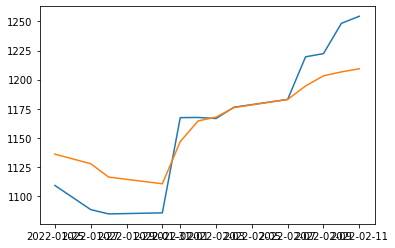

In [20]:
plt.plot(final_y_zeros.index[50:], (tf.squeeze(final_y_zeros[50:].to_numpy()).numpy())*k.values[0])
plt.plot(final_y_zeros.index[50:], preds)

In [21]:
model.save("LSTM_tata steel")

INFO:tensorflow:Assets written to: LSTM_tata steel\assets


INFO:tensorflow:Assets written to: LSTM_tata steel\assets
